In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

In [3]:
file_name = 'wheat_30_var_2_species.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 3
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(48384, 147, 1)
(12096, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [30]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [38]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 143, 32)           192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 28, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 896)               0         
                                                                 
 dense_6 (Dense)             (None, 1000)              897000    
                                                                 
 dense_7 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 899,194
Trainable params: 899,194
Non-trainable params: 0
________________________________________________

In [40]:
train_eva = []
test_eva = []

In [41]:
history_dataframe = pd.DataFrame() 

In [42]:
from IPython.display import clear_output

for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))
    
#     clear_output(wait=True)


Epoch:  1
378/378 - 17s - loss: 0.6472 - accuracy: 0.6120 - 17s/epoch - 44ms/step
for training
1512/1512 [==============================] - 9s 6ms/step - loss: 0.5846 - accuracy: 0.6991
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.5852 - accuracy: 0.6964

Epoch:  2
378/378 - 14s - loss: 0.5310 - accuracy: 0.7442 - 14s/epoch - 36ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.4776 - accuracy: 0.7841
for testing
378/378 [==============================] - 3s 6ms/step - loss: 0.4779 - accuracy: 0.7851

Epoch:  3
378/378 - 11s - loss: 0.4467 - accuracy: 0.7951 - 11s/epoch - 29ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.4096 - accuracy: 0.8155
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.4079 - accuracy: 0.8162

Epoch:  4
378/378 - 11s - loss: 0.3962 - accuracy: 0.8230 - 11s/epoch - 28ms/step
for training
1512/1512 [============================

1512/1512 [==============================] - 12s 8ms/step - loss: 0.1523 - accuracy: 0.9361
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.1485 - accuracy: 0.9403

Epoch:  30
378/378 - 11s - loss: 0.1437 - accuracy: 0.9423 - 11s/epoch - 28ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.1464 - accuracy: 0.9431
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.1460 - accuracy: 0.9422

Epoch:  31
378/378 - 10s - loss: 0.1430 - accuracy: 0.9426 - 10s/epoch - 26ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.1318 - accuracy: 0.9475
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.1294 - accuracy: 0.9494

Epoch:  32
378/378 - 11s - loss: 0.1406 - accuracy: 0.9431 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.1470 - accuracy: 0.9391
for testing
378/378 [====================

378/378 [==============================] - 2s 4ms/step - loss: 0.1121 - accuracy: 0.9591

Epoch:  58
378/378 - 9s - loss: 0.1248 - accuracy: 0.9492 - 9s/epoch - 24ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.1128 - accuracy: 0.9558
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.1110 - accuracy: 0.9593

Epoch:  59
378/378 - 9s - loss: 0.1240 - accuracy: 0.9507 - 9s/epoch - 25ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.1162 - accuracy: 0.9534
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.1145 - accuracy: 0.9564

Epoch:  60
378/378 - 9s - loss: 0.1237 - accuracy: 0.9503 - 9s/epoch - 24ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.1158 - accuracy: 0.9542
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.1147 - accuracy: 0.9562

Epoch:  61
378/378 - 9s - loss: 0.1189 - accuracy

for training
1512/1512 [==============================] - 11s 7ms/step - loss: 0.1174 - accuracy: 0.9534
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.1159 - accuracy: 0.9540

Epoch:  87
378/378 - 9s - loss: 0.1095 - accuracy: 0.9569 - 9s/epoch - 25ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0981 - accuracy: 0.9621
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0956 - accuracy: 0.9649

Epoch:  88
378/378 - 9s - loss: 0.1066 - accuracy: 0.9584 - 9s/epoch - 23ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0986 - accuracy: 0.9616
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0962 - accuracy: 0.9642

Epoch:  89
378/378 - 10s - loss: 0.1124 - accuracy: 0.9555 - 10s/epoch - 28ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.1123 - accuracy: 0.9562
for testing
378/378 [===========

378/378 [==============================] - 2s 4ms/step - loss: 0.0971 - accuracy: 0.9619

Epoch:  115
378/378 - 10s - loss: 0.0992 - accuracy: 0.9614 - 10s/epoch - 25ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0979 - accuracy: 0.9621
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0968 - accuracy: 0.9635

Epoch:  116
378/378 - 8s - loss: 0.1020 - accuracy: 0.9609 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0894 - accuracy: 0.9667
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0870 - accuracy: 0.9681

Epoch:  117
378/378 - 8s - loss: 0.0963 - accuracy: 0.9629 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0898 - accuracy: 0.9649
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0874 - accuracy: 0.9673

Epoch:  118
378/378 - 8s - loss: 0.0989 - ac

for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0887 - accuracy: 0.9659
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0865 - accuracy: 0.9673

Epoch:  144
378/378 - 8s - loss: 0.0914 - accuracy: 0.9653 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0829 - accuracy: 0.9688
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0806 - accuracy: 0.9701

Epoch:  145
378/378 - 8s - loss: 0.0919 - accuracy: 0.9651 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0968 - accuracy: 0.9619
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0970 - accuracy: 0.9636

Epoch:  146
378/378 - 8s - loss: 0.0906 - accuracy: 0.9652 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0821 - accuracy: 0.9692
for testing
378/378 [===========

378/378 [==============================] - 2s 4ms/step - loss: 0.0797 - accuracy: 0.9710

Epoch:  172
378/378 - 8s - loss: 0.0862 - accuracy: 0.9673 - 8s/epoch - 21ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0791 - accuracy: 0.9704
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0769 - accuracy: 0.9724

Epoch:  173
378/378 - 8s - loss: 0.0902 - accuracy: 0.9654 - 8s/epoch - 21ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0791 - accuracy: 0.9702
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0768 - accuracy: 0.9713

Epoch:  174
378/378 - 8s - loss: 0.0852 - accuracy: 0.9678 - 8s/epoch - 21ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0774 - accuracy: 0.9706
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0762 - accuracy: 0.9729

Epoch:  175
378/378 - 8s - loss: 0.0896 - accu

for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0779 - accuracy: 0.9705
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0758 - accuracy: 0.9714

Epoch:  201
378/378 - 11s - loss: 0.0822 - accuracy: 0.9697 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0929 - accuracy: 0.9644
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0884 - accuracy: 0.9661

Epoch:  202
378/378 - 11s - loss: 0.0820 - accuracy: 0.9689 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0744 - accuracy: 0.9724
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0732 - accuracy: 0.9730

Epoch:  203
378/378 - 11s - loss: 0.0815 - accuracy: 0.9693 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0743 - accuracy: 0.9719
for testing
378/378 [=

1512/1512 [==============================] - 10s 7ms/step - loss: 0.0851 - accuracy: 0.9667
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0847 - accuracy: 0.9675

Epoch:  229
378/378 - 11s - loss: 0.0818 - accuracy: 0.9691 - 11s/epoch - 29ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0741 - accuracy: 0.9723
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0723 - accuracy: 0.9726

Epoch:  230
378/378 - 10s - loss: 0.0810 - accuracy: 0.9695 - 10s/epoch - 26ms/step
for training
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0717 - accuracy: 0.9728
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0696 - accuracy: 0.9750

Epoch:  231
378/378 - 11s - loss: 0.0786 - accuracy: 0.9710 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.1211 - accuracy: 0.9505
for testing
378/378 [==============

1512/1512 [==============================] - 13s 8ms/step - loss: 0.0727 - accuracy: 0.9726
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0698 - accuracy: 0.9741

Epoch:  257
378/378 - 11s - loss: 0.0768 - accuracy: 0.9705 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0807 - accuracy: 0.9690
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0794 - accuracy: 0.9709

Epoch:  258
378/378 - 11s - loss: 0.0798 - accuracy: 0.9692 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0837 - accuracy: 0.9672
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0840 - accuracy: 0.9686

Epoch:  259
378/378 - 11s - loss: 0.0770 - accuracy: 0.9710 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0764 - accuracy: 0.9709
for testing
378/378 [==============

1512/1512 [==============================] - 13s 8ms/step - loss: 0.0731 - accuracy: 0.9722
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0724 - accuracy: 0.9721

Epoch:  285
378/378 - 11s - loss: 0.0749 - accuracy: 0.9719 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0782 - accuracy: 0.9704
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0757 - accuracy: 0.9711

Epoch:  286
378/378 - 12s - loss: 0.0731 - accuracy: 0.9726 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0668 - accuracy: 0.9758
for testing
378/378 [==============================] - 3s 9ms/step - loss: 0.0646 - accuracy: 0.9764

Epoch:  287
378/378 - 12s - loss: 0.0739 - accuracy: 0.9725 - 12s/epoch - 32ms/step
for training
1512/1512 [==============================] - 13s 9ms/step - loss: 0.0673 - accuracy: 0.9745
for testing
378/378 [==============

1512/1512 [==============================] - 7s 4ms/step - loss: 0.0788 - accuracy: 0.9708
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0753 - accuracy: 0.9727

Epoch:  313
378/378 - 8s - loss: 0.0735 - accuracy: 0.9726 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0636 - accuracy: 0.9761
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0628 - accuracy: 0.9771

Epoch:  314
378/378 - 8s - loss: 0.0710 - accuracy: 0.9730 - 8s/epoch - 21ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0882 - accuracy: 0.9655
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0892 - accuracy: 0.9645

Epoch:  315
378/378 - 8s - loss: 0.0684 - accuracy: 0.9740 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0632 - accuracy: 0.9765
for testing
378/378 [========================

378/378 [==============================] - 2s 4ms/step - loss: 0.0705 - accuracy: 0.9735

Epoch:  341
378/378 - 8s - loss: 0.0670 - accuracy: 0.9748 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0637 - accuracy: 0.9762
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0645 - accuracy: 0.9759

Epoch:  342
378/378 - 8s - loss: 0.0688 - accuracy: 0.9747 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0681 - accuracy: 0.9741
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0678 - accuracy: 0.9757

Epoch:  343
378/378 - 8s - loss: 0.0678 - accuracy: 0.9746 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 6s 4ms/step - loss: 0.0995 - accuracy: 0.9597
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.1008 - accuracy: 0.9606

Epoch:  344
378/378 - 8s - loss: 0.0690 - accu

for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0619 - accuracy: 0.9769
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0614 - accuracy: 0.9777

Epoch:  370
378/378 - 9s - loss: 0.0646 - accuracy: 0.9753 - 9s/epoch - 23ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0591 - accuracy: 0.9778
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0585 - accuracy: 0.9795

Epoch:  371
378/378 - 8s - loss: 0.0678 - accuracy: 0.9745 - 8s/epoch - 22ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0586 - accuracy: 0.9790
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0587 - accuracy: 0.9782

Epoch:  372
378/378 - 9s - loss: 0.0648 - accuracy: 0.9758 - 9s/epoch - 23ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0741 - accuracy: 0.9708
for testing
378/378 [===========

378/378 [==============================] - 2s 4ms/step - loss: 0.0594 - accuracy: 0.9778

Epoch:  398
378/378 - 9s - loss: 0.0638 - accuracy: 0.9758 - 9s/epoch - 23ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0582 - accuracy: 0.9784
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0579 - accuracy: 0.9799

Epoch:  399
378/378 - 9s - loss: 0.0632 - accuracy: 0.9761 - 9s/epoch - 23ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0553 - accuracy: 0.9801
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0548 - accuracy: 0.9798

Epoch:  400
378/378 - 9s - loss: 0.0626 - accuracy: 0.9764 - 9s/epoch - 24ms/step
for training
1512/1512 [==============================] - 7s 4ms/step - loss: 0.0555 - accuracy: 0.9796
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0566 - accuracy: 0.9783


In [43]:
history_dataframe

,loss,accuracy
0,0.647243,0.612041
1,0.530980,0.744192
2,0.446708,0.795118
3,0.396233,0.822958
4,0.355914,0.845321
...,...,...
395,0.062748,0.976128
396,0.063072,0.975860
397,0.063788,0.975839
398,0.063166,0.976087


In [44]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [45]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

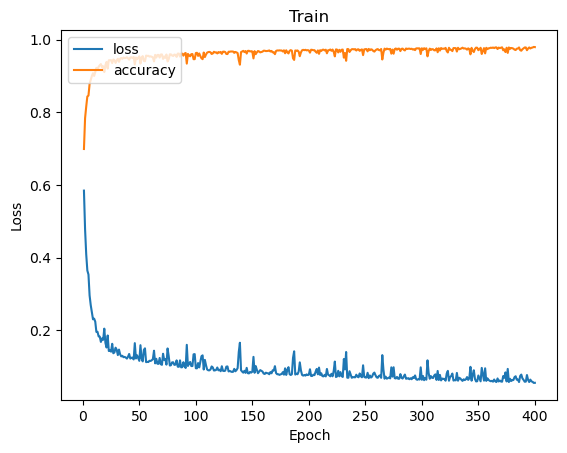

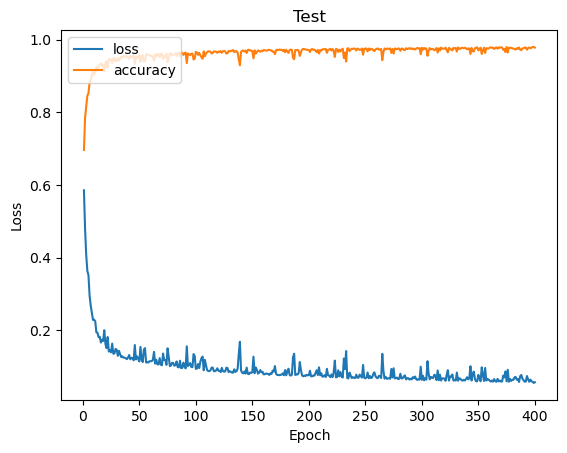

In [46]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])